In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat

In [206]:
c = C_time[25]
-D*np.sum((c[11+i_eff]-c[9+i_eff])[20:29,20:29]/dx)

0.04527393228045405

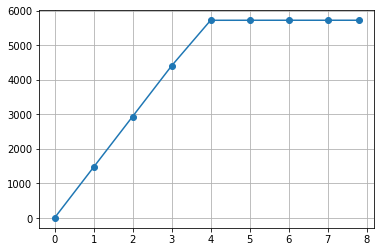

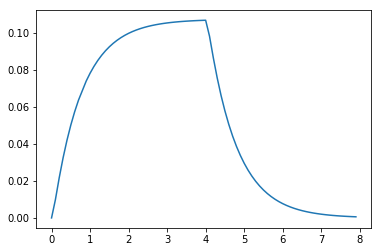

In [211]:
data = loadmat('A_m-m.mat')
constants = loadmat('add.mat')

C_time = data['And1'][0][0][0]

Cb_time = data['And1'][0][0][1]

D = 7*10**(-8)
dx = constants['dx'][0][0]
dy = constants['dy'][0][0]
dz = constants['dz'][0][0]
constants

i_eff = 0

i_eff = int(i_eff)

times  = []
fluxes = []
for t_idx, c in enumerate(C_time):
    if t_idx != 7:
        fluxes.append(-D*np.sum((c[11+i_eff]-c[9+i_eff])[20:29,20:29]/dx)*9)
        times.append(6*t_idx/60)

fluxes1 = fluxes[:7] + [fluxes[6]] + fluxes[7:]
times2 = times[:7] + [times[6]+0.1]+times[7:]

c_permeated2 = [0]
for i in range(1, len(times2)):
    c_permeated2.append(
        fluxes1[i]*(times2[i]-times2[i-1])*3600 + c_permeated2[-1]
    )

plt.plot(times2[::10]+[times2[-1]],c_permeated2[::10]+[c_permeated2[-1]], 'o-')
plt.grid()
plt.show()

cb_din2 = [0]
ts2 = [0]
for t_idx, cb in enumerate(Cb_time):
    if t_idx != 7:
        cb_din2.append(
            np.sum(cb[10,20:28,20:28])*dy*dz*1e3
        )
        ts2.append((t_idx+1)*0.1)

plt.plot(ts2, cb_din2)

In [143]:
constants

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Sep  9 10:57:19 2018',
 '__version__': '1.0',
 '__globals__': [],
 'dx': array([[0.00175]]),
 'dy': array([[0.0005]]),
 'dz': array([[0.0005]]),
 'needle_x': array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]], dtype=uint8),
 'needle_y': array([[21, 22, 23, 24, 25, 26, 27, 28, 29]], dtype=uint8)}

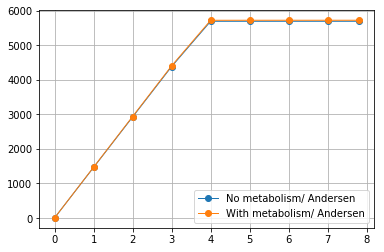

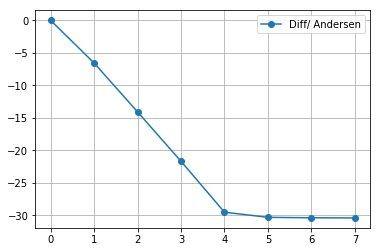

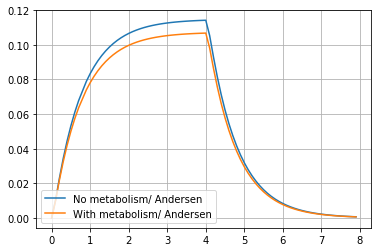

In [214]:
data = loadmat('A_no_m-m.mat')
constants = loadmat('add.mat')

C_time = data['And0'][0][0][0]

Cb_time = data['And0'][0][0][1]

D = 7*10**(-8)
dx = constants['dx'][0][0]
dy = constants['dy'][0][0]
dz = constants['dz'][0][0]
constants

i_eff = 0

i_eff = int(i_eff)

times  = []
fluxes = []
for t_idx, c in enumerate(C_time):
    if t_idx != 7:
        fluxes.append(-D*np.sum((c[11+i_eff]-c[9+i_eff])[20:29,20:29]/dx)*9)
        times.append(6*t_idx/60)

fluxes1 = fluxes[:7] + [fluxes[6]] + fluxes[7:]
times1 = times[:7] + [times[6]+0.1]+times[7:]

c_permeated = [0]
for i in range(1, len(times1)):
    c_permeated.append(
        fluxes1[i]*(times1[i]-times1[i-1])*3600 + c_permeated[-1]
    )

plt.plot(times1[::10]+[times1[-1]],c_permeated[::10]+[c_permeated[-1]], 'o-', label='No metabolism/ Andersen', lw=1)
plt.plot(times2[::10]+[times2[-1]],c_permeated2[::10]+[c_permeated2[-1]], 'o-', label='With metabolism/ Andersen', lw=1)
plt.legend()
plt.grid()
plt.show()

plt.plot(times1[::10],np.array(c_permeated)[::10]-np.array(c_permeated2)[::10], 'o-', label='Diff/ Andersen')
plt.legend()
plt.grid()
plt.show()

cb_din = [0]
ts = [0]
for t_idx, cb in enumerate(Cb_time):
    if t_idx != 7:
        cb_din.append(
            np.sum(cb[10,20:28,20:28])*dy*dz*1e3
        )
        ts.append((t_idx+1)*0.1)

plt.plot(ts, cb_din, label='No metabolism/ Andersen')
plt.plot(ts2, cb_din2, label='With metabolism/ Andersen')
plt.legend()
plt.grid()
plt.show()

In [184]:
C_time.shape

(79, 20, 50, 50)

In [64]:
c_temp = C_time[5,:,:,23]

In [65]:
x = np.arange(0, 0.035,dx)
y = np.arange(0, 0.025, dy)

In [66]:
c_temp.shape

(20, 50)

In [67]:
y.shape

(50,)

In [68]:
x.shape

(20,)

In [80]:
gradX = []
for i in range(1,19):
    gradX.append(-D*(c_temp[i+1]-c_temp[i-1])/dx)

gradX = np.array(gradX)[:,1:-1]

gradY = []
for i in range(1,49):
    gradY.append(-D*(c_temp[:,i+1]-c_temp[:,i-1])/dy)

gradY = np.array(gradY).T[1:-1,:]

In [73]:
gradX.shape

(18, 48)

In [74]:
gradX[0:9,:]=0

gradY[0:9,:]=0

In [76]:
gradY.shape

(18, 48)

In [77]:
c_temp.T[1:-1,1:-1].shape

(48, 18)

In [78]:
l = 9*0.00175

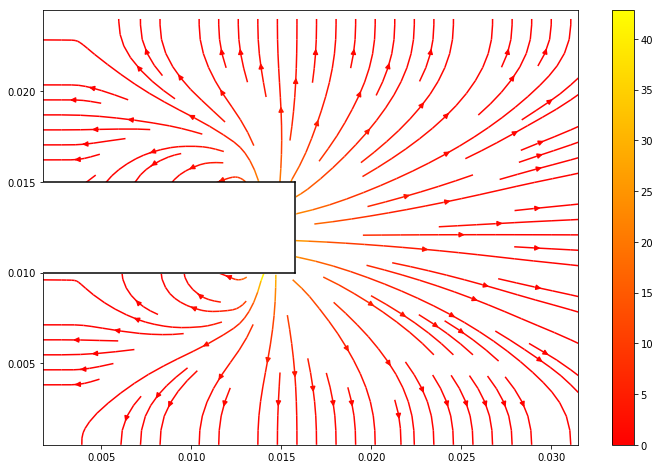

In [87]:
fig0, ax0 = plt.subplots()
fig0.set_size_inches(12,8)
strm = ax0.streamplot(x[1:-1], y[1:-1], gradX.T, gradY.T, color=c_temp.T[1:-1,1:-1],
                     cmap=plt.cm.autumn)
fig0.colorbar(strm.lines)
plt.fill_between([0.00175, l], [0.01,0.01], [0.015,0.015], color='white', zorder=100)
plt.plot([0.0001, l], [0.01,0.01], '-k', zorder=101)
plt.plot([0.0001, l], [0.015,0.015], '-k', zorder=101)
plt.plot([l, l], [0.01,0.015],'-k', zorder=101)
plt.xlim(0.00175)
plt.ylim(dy, 0.025-dy)
plt.show()

In [145]:
data2d = loadmat('all_2d.mat')

In [147]:
data2d.keys()

dict_keys(['__header__', '__version__', '__globals__', 'And_2d_mm', 'And_2d_nm', 'Eich_2d_mm', 'Eich_2d_nm', 'Koike_2d_mm', 'Koike_2d_nm'])

In [150]:
C2d_time = data2d['And_2d_mm'][0][0][0]
Cb2d_time = data2d['And_2d_mm'][0][0][1]

In [174]:
C2d_time.shape

(9, 20, 50)

In [178]:
times

[0, 1, 2, 3, 4, 5, 6, 8]

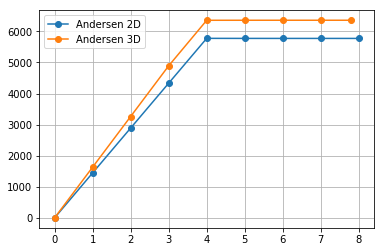

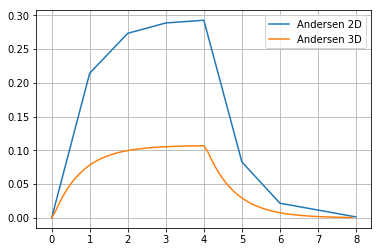

In [180]:
D = 7*10**(-8)
dx = constants['dx'][0][0]
dy = constants['dy'][0][0]
dz = constants['dz'][0][0]
constants

i_eff = 0

i_eff = int(i_eff)

times  = []
fluxes = []
for t_idx, c in enumerate(C2d_time):
        fluxes.append(-D*np.sum((c[11+i_eff]-c[9+i_eff])[20:29]/dx)*90)
        times.append(t_idx)

c_permeated = [0]
for i in range(1, len(times)):
    c_permeated.append(
        fluxes[i]*(times[i]-times[i-1])*3600 + c_permeated[-1]
    )

plt.plot(times,c_permeated, 'o-', label='Andersen 2D')
plt.plot(times2[::10]+[times2[-1]],c_permeated2[::10]+[c_permeated2[-1]], 'o-', label='Andersen 3D')
plt.legend()
plt.grid()
plt.show()

cb_din = [0]
ts = [0]
for t_idx, cb in enumerate(Cb2d_time):
    if t_idx != 7:
        cb_din.append(
            np.sum(cb[10,20:28])*dy*dz*9*1e3
        )
        ts.append(t_idx)

plt.plot(ts, cb_din, label='Andersen 2D')
plt.plot(ts2, cb_din2, label='Andersen 3D')
plt.legend()
plt.grid()
plt.show()

In [218]:
list(data2d.keys())[3:]

['And_2d_mm',
 'And_2d_nm',
 'Eich_2d_mm',
 'Eich_2d_nm',
 'Koike_2d_mm',
 'Koike_2d_nm']

### Useful constants

In [2]:
# Andersen et al. (1979)
Vb = 2.63*10**4
Vt = 5.18*10**4
Ke = 1.58*10**(-4)
K12 = 2.19*10**(-4)
K21 = 1.11*10**(-4)
K = 5.61*10**(-4)
Dz=Dy=Dx = 7*10**(-8)

Lc = 50*10**(-3)
Ld = 250*10**(-3)
Lu = 300*10**(-3)
T_run = 8*3600
T_input = 4*3600

W = Lu + Ld
Depth = 0.02
h_eff = 0.008

dx = Depth/20
dy = W/55
dz = W/55
# dt = 0.25*(2*(Dx/dx**2 + Dy/dy**2))**(-1)
dt = 0.1

x = np.arange(0, Depth+dx, dx)
y = np.arange(-Ld, Lu+dy, dy)
z = np.arange(-Ld, Lu+dz, dz)

Nx = len(x)
Ny = len(y)
Nz = len(z)
Nt = T_run // dt

In [3]:
r = .2
w = (1-r)/r
c = np.zeros((Nx, Ny, Nz))
cb = np.zeros((Nx, Ny, Nz))
dCx0 = 0
dCy = 0

### Initial conditions

### Plot function:

In [0]:
def plot_concentration(c):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    Xax, Yax, Zax = np.meshgrid(x,y,z)
    surf = ax.contour(Zax, Yax, Xax, c, rstride=1, cstride=1,
                           cmap=cm.viridis, linewidth=0, antialiased=False)
    plt.colorbar(surf)
#     ax.set_xlim(0,1)
#     ax.set_ylim(-Ld, Lu)
#     #ax.set_zlim(0, 1.2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('concentration')
    plt.show()

In [0]:
def plot_concentration_contour(c, title):
    fig = plt.figure()
#     ax = fig.gca(projection='3d')
    Xax, Yax = np.meshgrid(x,y)
    min_val = np.min(c)
    max_val = np.max(c)
    contour = plt.contourf(Xax, Yax, c.T, cmap=cm.viridis, levels=np.linspace(min_val, max_val, 51))
    plt.colorbar(contour)
#     plt.xlim(0,1)
#     plt.ylim(-Ld, Lu)
#     ax.set_zlim(0, 1.2)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    if title:
        plt.title('After '+str(title)+' sec')
#     ax.set_zlabel('concentration')
#     plt.savefig('microneedle/'+title+'.png')
    plt.show()

### Main text

In [4]:
N_coated_y = len(list(filter(lambda x: 0 <= x <= Lc, y)))
N_coated_z = len(list(filter(lambda x: 0 <= x <= Lc, z)))
c_init = 43.#/N_coated/N_coated_z

In [99]:
%matplotlib inline
for i in range(Nx):
    for j in range(Ny):
        for k in range(Nz):
            if (0 <= y[j] <= Lc) and (0 <= z[k] <= Lc) and i == int(h_eff/dx):
                c[i,j,k] = c_init
            else:
                c[i,j,k] = 0

cb = np.zeros((Nx, Ny, Nz))
# plot_concentration_contour(c, '')

In [100]:
sum_concentration = []
cu_x = dt/dx**2 * Dx
cu_y = dt/dy**2 * Dy
cu_z = dt/dz**2 * Dz
EPS=1e-5
y0 = np.logical_and(y>=-EPS, y<=EPS)
yLC = np.logical_and(y>=-EPS+Lc, y<=EPS+Lc)
z0 = np.logical_and(z>=-EPS, z<=EPS)
zLC = np.logical_and(z>=-EPS+Lc, z<=EPS+Lc)

if np.any(y0) and np.any(yLC) and np.any(z0) and np.any(zLC):
    j0 = np.argsort(y0)[-1]
    jLC = np.argsort(yLC)[-1]
    k0 = np.argsort(z0)[-1]
    kLC = np.argsort(zLC)[-1]
else:
    print('You need more accurate meshing')
    raise ValueError()
    
for t_idx in np.arange(Nt):
    c_temp = c.copy()
    cb_temp = cb.copy()
    if t_idx*dt % 3600 == 0:
        sum_concentration.append(np.sum(cb))
        print('Iteration = '+str(t_idx))
#         plot_concentration_contour(c, str(t_idx*dt))
        
#     Boundary conditions
    c[0,:] = 1/3*(4*c[1,:,:] - c[2,:,:])
    c[Nx-1,:,:] = 0#1/3*(4*c[Nx-2,:] - c[Nx-1,:])#/(3+2*w*dx)
        
    # Along y = Lu and y = -Ld
    c[:,Ny-1,:] = 1/3*(4*c[:,Ny-2,:] - c[:,Ny-3,:])
    c[:,0,:] = 1/3*(4*c[:,1,:] - c[:,2,:])
    
    # Along z = Lu and z = -Ld
    c[:, :, Nz-1] = 1/3*(4*c[:, :, Nz-2] - c[:, :, Nz-3])
    c[:, :, 0] = 1/3*(4*c[:, :, 1] - c[:, :, 2])
    
    # Along y needle edge
    c[:int(h_eff/dx),j0,k0:kLC] = 1/3*(4*c[:int(h_eff/dx),j0-1,k0:kLC] - c[:int(h_eff/dx),j0-2,k0:kLC])
    c[:int(h_eff/dx),jLC,k0:kLC] = 1/3*(4*c[:int(h_eff/dx),jLC+1,k0:kLC] - c[:int(h_eff/dx),jLC+2,k0:kLC])
    # Along z needle edge
    c[:int(h_eff/dx),j0:jLC,k0] = 1/3*(4*c[:int(h_eff/dx),j0:jLC,k0-1] - c[:int(h_eff/dx),j0:jLC,k0-2])
    c[:int(h_eff/dx),j0:jLC,kLC] = 1/3*(4*c[:int(h_eff/dx),j0:jLC,kLC+1] - c[:int(h_eff/dx),j0:jLC,kLC+2])
    
#     # Free concentration: -Ld<y<Ld and -Ld<z<0
#     c[1:Nx-1,1:Ny-1,1:k0-1] = c_temp[1:Nx-1,1:Ny-1,1:k0-1] \
#                             +cu_x*(c_temp[2:Nx,1:Ny-1,1:k0-1]+c_temp[0:Nx-2,1:Ny-1,1:k0-1]-2*c_temp[1:Nx-1,1:Ny-1,1:k0-1]) \
#                             +cu_y*(c_temp[1:Nx-1,0:Ny-2,1:k0-1]+c_temp[1:Nx-1,2:Ny,1:k0-1]-2*c_temp[1:Nx-1,1:Ny-1,1:k0-1]) \
#                             +cu_z*(c_temp[1:Nx-1,1:Ny-1,0:k0-2]+c_temp[1:Nx-1,1:Ny-1,2:k0]-2*c_temp[1:Nx-1,1:Ny-1,1:k0-1]) \
#                             -dt*K*c_temp[1:Nx-1,1:Ny-1,1:k0-1] \
#                             +dt*(K12*cb_temp[1:Nx-1,1:Ny-1,1:k0-1]*Vb/Vt - K21*c_temp[1:Nx-1,1:Ny-1,1:k0-1])
#     cb[1:Nx-1,1:Ny-1,1:k0-1] = cb_temp[1:Nx-1,1:Ny-1,1:k0-1] \
#                             +dt*(-(Ke + K12)*cb_temp[1:Nx-1,1:Ny-1,1:k0-1] + K21*c[1:Nx-1,1:Ny-1,1:k0-1]*Vt/Vb)
        
#     # Free concentration: -Ld<y<Ld and Lc<z<Lu
#     c[1:Nx-1,1:Ny-1,kLC+1:Nz-1] = c_temp[1:Nx-1,1:Ny-1,kLC+1:Nz-1] \
#                             +cu_x*(c_temp[2:Nx,1:Ny-1,kLC+1:Nz-1]+c_temp[0:Nx-2,1:Ny-1,kLC+1:Nz-1]-2*c_temp[1:Nx-1,1:Ny-1,kLC+1:Nz-1]) \
#                             +cu_y*(c_temp[1:Nx-1,0:Ny-2,kLC+1:Nz-1]+c_temp[1:Nx-1,2:Ny,kLC+1:Nz-1]-2*c_temp[1:Nx-1,1:Ny-1,kLC+1:Nz-1]) \
#                             +cu_z*(c_temp[1:Nx-1,1:Ny-1,kLC:Nz-2]+c_temp[1:Nx-1,1:Ny-1,kLC+2:Nz]-2*c_temp[1:Nx-1,1:Ny-1,kLC+1:Nz-1]) \
#                             -dt*K*c_temp[1:Nx-1,1:Ny-1,kLC+1:Nz-1] \
#                             +dt*(K12*cb_temp[1:Nx-1,1:Ny-1,kLC+1:Nz-1]*Vb/Vt - K21*c_temp[1:Nx-1,1:Ny-1,kLC+1:Nz-1])
#     cb[1:Nx-1,1:Ny-1,kLC+1:Nz-1] = cb_temp[1:Nx-1,1:Ny-1,kLC+1:Nz-1] \
#                             +dt*(-(Ke + K12)*cb_temp[1:Nx-1,1:Ny-1,kLC+1:Nz-1] + K21*c[1:Nx-1,1:Ny-1,kLC+1:Nz-1]*Vt/Vb)
        
#     # Free concentration: -Ld<y<0 and 0<=z<=Lc
#     c[1:Nx-1,1:j0-1,k0:kLC] = c_temp[1:Nx-1,1:j0-1,k0:kLC] \
#                             +cu_x*(c_temp[2:Nx,1:j0-1,k0:kLC]+c_temp[0:Nx-2,1:j0-1,k0:kLC]-2*c_temp[1:Nx-1,1:j0-1,k0:kLC]) \
#                             +cu_y*(c_temp[1:Nx-1,0:j0-2,k0:kLC]+c_temp[1:Nx-1,2:j0,k0:kLC]-2*c_temp[1:Nx-1,1:j0-1,k0:kLC]) \
#                             +cu_z*(c_temp[1:Nx-1,1:j0-1,k0-1:kLC-1]+c_temp[1:Nx-1,1:j0-1,k0+1:kLC+1]-2*c_temp[1:Nx-1,1:j0-1,k0:kLC]) \
#                             -dt*K*c_temp[1:Nx-1,1:j0-1,k0:kLC] \
#                             +dt*(K12*cb_temp[1:Nx-1,1:j0-1,k0:kLC]*Vb/Vt - K21*c_temp[1:Nx-1,1:j0-1,k0:kLC])
#     cb[1:Nx-1,1:j0-1,k0:kLC] = cb_temp[1:Nx-1,1:j0-1,k0:kLC] \
#                             +dt*(-(Ke + K12)*cb_temp[1:Nx-1,1:j0-1,k0:kLC] + K21*c[1:Nx-1,1:j0-1,k0:kLC]*Vt/Vb)
        
#     # Free concentration: Lc<y<Lu and 0<=z<=Lc
#     c[1:Nx-1,jLC+1:Ny-1,k0:kLC] = c_temp[1:Nx-1,jLC+1:Ny-1,k0:kLC] \
#                             +cu_x*(c_temp[2:Nx,jLC+1:Ny-1,k0:kLC]+c_temp[0:Nx-2,jLC+1:Ny-1,k0:kLC]-2*c_temp[1:Nx-1,jLC+1:Ny-1,k0:kLC]) \
#                             +cu_y*(c_temp[1:Nx-1,jLC:Ny-2,k0:kLC]+c_temp[1:Nx-1,jLC+2:Ny,k0:kLC]-2*c_temp[1:Nx-1,jLC+1:Ny-1,k0:kLC]) \
#                             +cu_z*(c_temp[1:Nx-1,jLC+1:Ny-1,k0-1:kLC-1]+c_temp[1:Nx-1,jLC+1:Ny-1,k0+1:kLC+1]-2*c_temp[1:Nx-1,jLC+1:Ny-1,k0:kLC]) \
#                             -dt*K*c_temp[1:Nx-1,jLC+1:Ny-1,k0:kLC] \
#                             +dt*(K12*cb_temp[1:Nx-1,jLC+1:Ny-1,k0:kLC]*Vb/Vt - K21*c_temp[1:Nx-1,jLC+1:Ny-1,k0:kLC])
#     cb[1:Nx-1,jLC+1:Ny-1,k0:kLC] = cb_temp[1:Nx-1,jLC+1:Ny-1,k0:kLC] \
#                             +dt*(-(Ke + K12)*cb_temp[1:Nx-1,jLC+1:Ny-1,k0:kLC] + K21*c[1:Nx-1,jLC+1:Ny-1,k0:kLC]*Vt/Vb)

#    Implicit FD method
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            for k in range(1,Nz-1):
                if not (i < int(h_eff/dx) and 0 <= y[j] <= Lc):
                    c[i,j,k] = c_temp[i,j,k] \
                               + cu_x*(c_temp[i+1,j,k] - 2*c_temp[i,j,k] + c_temp[i-1,j,k]) \
                               + cu_y*(c_temp[i,j-1,k] + c_temp[i,j+1,k] - 2*c_temp[i,j,k]) \
                               + cu_z*(c_temp[i,j,k-1] + c_temp[i,j,k+1] - 2*c_temp[i,j,k]) \
                               - K*c[i,j,k]*dt \
                               + dt*(K12*cb_temp[i,j,k]*Vb/Vt - K21*c_temp[i,j,k])
                    cb[i,j,k] = cb_temp[i,j,k] + dt*(-(Ke + K12)*cb_temp[i,j,k] + K21*c[i,j,k]*Vt/Vb)
     
    if t_idx*dt <= T_input:
        c[int(h_eff/dx),np.logical_and(y>=0, y<=Lc),np.logical_and(z>=0, z<=Lc)] = c_init
    

Iteration = 0.0


KeyboardInterrupt: 

## Динамика концентрации в крови

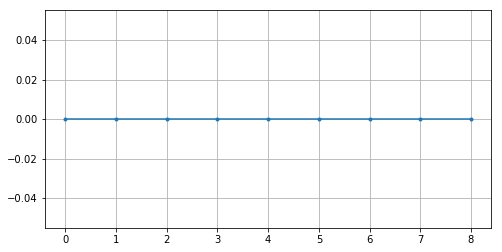

In [98]:
sum_concentration.append(np.sum(cb))
plt.figure(figsize=(8,4))
plt.plot(np.array(sum_concentration)/1000/((Ld+Lu)*Depth), '.-')
plt.grid()

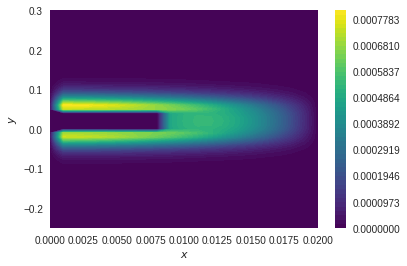

In [63]:
c1 = c.copy()
cb1 = cb.copy()
%matplotlib inline
plot_concentration_contour(cb, '')

## Попробуем без метаболизма

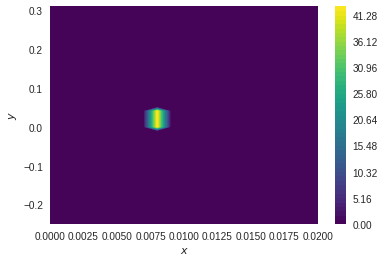

In [8]:
%matplotlib inline
for i in range(Nx):
    for j in range(Ny):
        if (0 <= y[j] <= Lc) and i == int(h_eff/dx):
            c[i,j] = c_init
        else:
            c[i,j] = 0

cb = np.zeros((Nx, Ny))
plot_concentration_contour(c, '')
K = 0
Dy = Dx

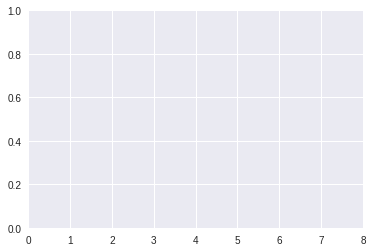

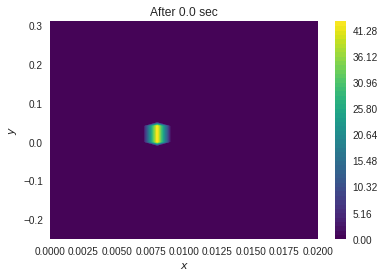

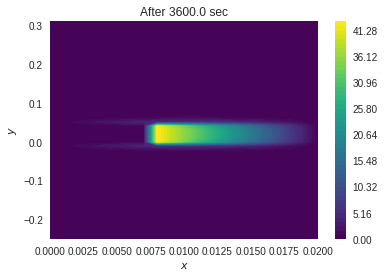

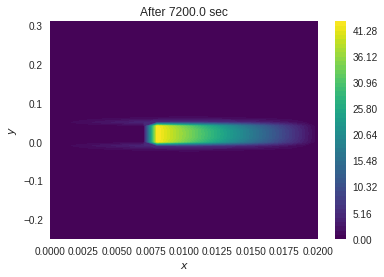

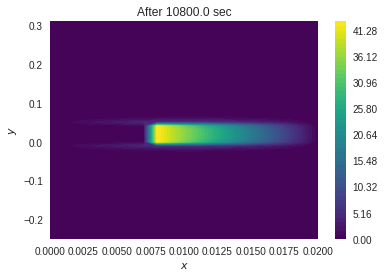

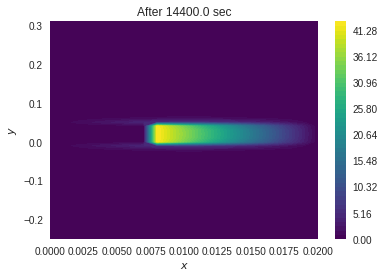

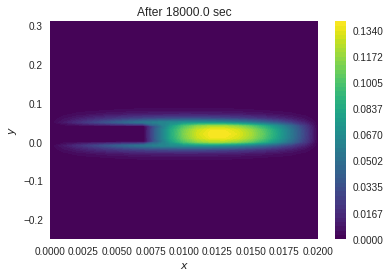

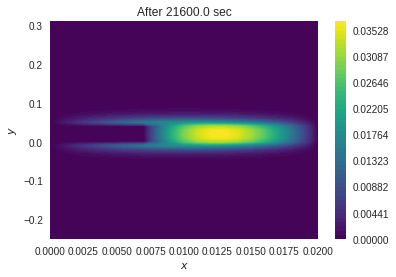

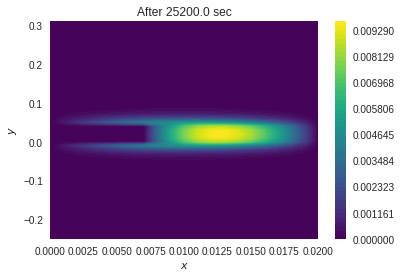

In [9]:
fig, ax = plt.subplots()
ax.set_xlim(0,8)
plt.show()
sum_concentration = []
cu_x = dt/dx**2 * Dx
cu_y = dt/dy**2 * Dy
for t_idx in np.arange(Nt):
    c_temp = c.copy()
    cb_temp = cb.copy()
    if t_idx*dt % 3600 == 0:
        sum_concentration.append(np.sum(cb))
        plot_concentration_contour(c, str(t_idx*dt))
        if t_idx > 0:
            ax.plot(sum_concentration, '.-')
        
#     Boundary conditions
    c[0, :] = 1/3*(4*c[1,:] - c[2,:])
    c[Nx-1,:] = 0#1/3*(4*c[Nx-2,:] - c[Nx-1,:])#/(3+2*w*dx)
        
    # Along y = Lu and y = -Ld
    c[:, Ny-1] = 1/3*(4*c[:, Ny-2] - c[:, Ny-3])
    c[:, 0] = 1/3*(4*c[:, 1] - c[:, 2])
    
#     # Along z = Lu and z = -Ld
#     c[:, :, Nz-1] = 1/3*(4*c[:, :, Nz-2] - c[:, :, Nz-3])
#     c[:, :, 0] = 1/3*(4*c[:, :, 1] - c[:, :, 2])
    
    

#    Implicit FD method
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
                if (i < int(h_eff/dx) and 0<=(y[j] - Lc)<1e-5):
                    c[i, j] = 1/3*(4*c[i, j+1] - c[i, j+2])
                if (i < int(h_eff/dx) and 0<=(-y[j])<1e-5):
                    c[i, j] = 1/3*(4*c[i, j-1] - c[i, j-2])
                if not (i < int(h_eff/dx) and 0 <= y[j] <= Lc):
                    c[i,j] = c_temp[i,j] + cu_x*(c_temp[i+1,j] - 2*c_temp[i,j] + c_temp[i-1,j]) \
                                     + cu_y*(c_temp[i,j-1] + c_temp[i,j+1] - 2*c_temp[i,j]) \
                                     + dt*(K12*cb_temp[i,j]*Vb/Vt - K21*c_temp[i,j])
                    cb[i,j] = cb_temp[i,j] + dt*(-(Ke + K12)*cb_temp[i,j] + K21*c[i,j]*Vt/Vb)
     
    if t_idx*dt <= T_input:
        c[int(h_eff/dx), np.logical_and(y>=0, y<=Lc)] = c_init
    

In [1]:
sum_concentration.append(np.sum(cb)/(Nx*Ny))
plt.figure(figsize=(8,4))
plt.plot(np.array(sum_concentration)/1000, '.-')
plt.grid()

NameError: ignored

In [0]:
c4 = c.copy()
cb4 = cb.copy()

In [0]:
np.sum(cb)

418.0973338768862

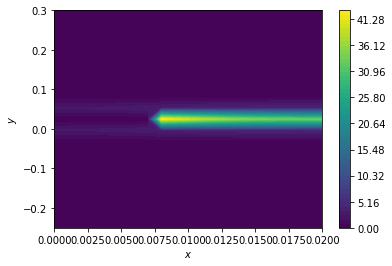

In [0]:
plot_concentration_contour(c4, "")

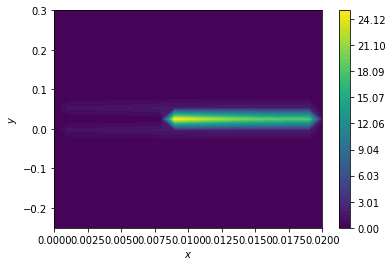

In [0]:
plot_concentration_contour(cb4, "")

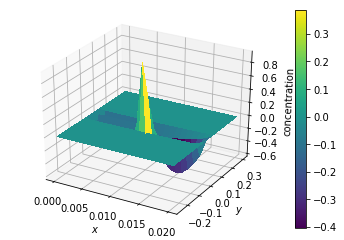

In [0]:
plot_concentration(cb1-cb2)

# Одномерный случай (Dy = 0)

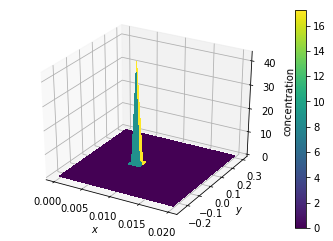

In [0]:
%matplotlib inline
for i in range(Nx):
    for j in range(Ny):
        if (0 <= y[j] <= Lc) and i == int(h_eff/dx):
            c[i,j] = 43.
        else:
            c[i,j] = 0

cb = np.zeros((Nx, Ny))
plot_concentration(c)
K = 5.61*10**(-4)
Dy = 0

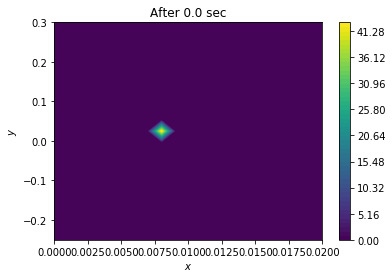

In [0]:
cu_x = dt/dx**2 * Dx
cu_y = dt/dy**2 * Dy
for t_idx in np.arange(Nt//4):
    c_temp = c.copy()
    cb_temp = cb.copy()
    if t_idx*dt % 3600 == 0:
        plot_concentration_contour(c, str(t_idx*dt))
        
#     Boundary conditions
    c[0, :] = 1/3*(4*c[1,:] - c[2,:]) - K*c[0, :]
    c[Nx-1,:] = 1/3*(4*c[Nx-2,:] - c[Nx-1,:])/(3+2*w*dx)
        
    # Along y = Lu and y = -Ld
    c[:, Ny-1] = 1/3*(4*c[:, Ny-2] - c[:, Ny-3])
    c[:, 0] = 1/3*(4*c[:, 1] - c[:, 2])

#    Implicit FD method
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            if not (i <= int(h_eff/dx) and 0 <= y[j] <= Lc):
                c[i,j] = c_temp[i,j] + cu_x*(c_temp[i+1,j] - 2*c_temp[i,j] + c_temp[i-1,j]) \
                                 + cu_y*(c_temp[i,j-1] + c_temp[i,j+1] - 2*c_temp[i,j]) - K*c[i,j]*dt \
                                 + dt*(K12*cb_temp[i,j]*Vb/Vt - K21*c_temp[i,j])
                cb[i,j] = cb_temp[i,j] + dt*(-(Ke + K12)*cb_temp[i,j] + K21*c[i,j]*Vt/Vb)

In [0]:
c3 = c.copy()
cb3 = cb.copy()

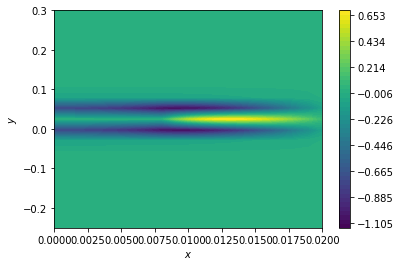

In [0]:
plot_concentration_contour(c3-c1, "")

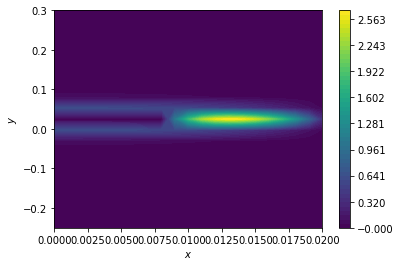

In [0]:
plot_concentration_contour(c2-c1, "")